In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 200
pd.set_option('display.max_columns', 5000)
from tqdm import tqdm
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow import keras
from keras import regularizers
from keras.metrics import MeanAbsoluteError
from keras import layers as l
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.metrics import confusion_matrix, mean_absolute_error
from sklearn.pipeline import Pipeline
#!pip install category_encoders
from sklearn.model_selection import  train_test_split
from sklearn import model_selection
from category_encoders import TargetEncoder

In [2]:
data = pd.read_csv("train_los.csv")
test = pd.read_csv("test_los.csv")
submission_csv = pd.read_csv("sample_sol_los.csv")

In [2]:
submission_csv = pd.read_csv("sample_sol_los.csv")

In [4]:
extra_diagnoses = pd.read_csv("extra_diagnoses.csv")

In [5]:
extra_diagnoses.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


In [6]:
extra = extra_diagnoses.copy()
unique = data["subject_id"].unique()
unique

array([55440, 28424, 86233, ...,  9725, 22337, 94290], dtype=int64)

In [7]:
dicto = {}
for n in tqdm(unique):
    dicto.update({n: len(extra.query("SUBJECT_ID == {}".format(n))["HADM_ID"].unique())})


100%|██████████| 10959/10959 [01:06<00:00, 164.37it/s]


In [8]:
unique = data["hadm_id"].unique()
dicto2 = {}
for n in tqdm(unique):
    dicto2.update({n: len(extra.query("HADM_ID == {}".format(n))["ICD9_CODE"].unique())})
    

100%|██████████| 13025/13025 [01:08<00:00, 190.21it/s]


In [9]:
dicto3 = {}
for n in tqdm(unique):
    dicto3.update({n: extra.query("HADM_ID == {}".format(n))["ICD9_CODE"].unique()})


100%|██████████| 13025/13025 [01:08<00:00, 191.38it/s]


In [10]:
data["num_stays"] = data["subject_id"].map(dicto)
data["num_dis"] = data["hadm_id"].map(dicto2)
data["dis"] = data["hadm_id"].map(dicto3)

In [11]:
data["dis"].head(10)

0    [5789, 51881, 41071, 42831, 42732, 2851, 53550...
1    [56211, 5185, 9973, 5180, 9341, 99859, 6822, 9...
2    [1625, 5185, 486, 5180, 9341, 5119, 5990, 2762...
3    [49322, 5849, 27651, 4659, 40390, 5859, 25002,...
4    [41511, 42831, 5119, 5121, 1628, 1985, 29632, ...
5    [4241, 99812, 41401, 4139, 4019, 2724, 25000, ...
6    [41011, 5845, 42821, 7907, 4280, 5853, 42731, ...
7    [3941, 3940, 5849, 5990, 2851, 5119, 4239, 427...
8    [85206, 2930, 8024, 8026, 8028, 87349, 29690, ...
9    [41401, 42823, 4271, 45829, 2875, 4254, 25000,...
Name: dis, dtype: object

In [12]:
unique = test["subject_id"].unique()
dicto = {}
for n in tqdm(unique):
    dicto.update({n: len(extra.query("SUBJECT_ID == {}".format(n))["HADM_ID"].unique())})
unique = test["hadm_id"].unique()
dicto2 = {}
for n in tqdm(unique):
    dicto2.update({n: len(extra.query("HADM_ID == {}".format(n))["ICD9_CODE"].unique())})
dicto3 = {}
for n in tqdm(unique):
    dicto3.update({n: extra.query("HADM_ID == {}".format(n))["ICD9_CODE"].unique()})


100%|██████████| 11217/11217 [00:58<00:00, 193.16it/s]


In [13]:
test["num_stays"] = test["subject_id"].map(dicto)
test["num_dis"] = test["hadm_id"].map(dicto2)
test["dis"] = test["hadm_id"].map(dicto3)

In [14]:
test["nthstay"] = test["hadm_id"]*np.nan
stacked = pd.concat([test,data], axis = 0)
stacked["ADMITTIME"] = pd.to_datetime(stacked["ADMITTIME"])
stacked.sort_values(by ="ADMITTIME",ascending = True, inplace = True)


In [15]:
dicto = {}
for n in tqdm(range(len(stacked))):
    temp = stacked["subject_id"].iloc[n]
    keys = dicto.keys()
    if temp in keys:
        v = dicto[temp] + 1
        dicto[temp] = v
        stacked["nthstay"].iloc[n] = v
    else:
        dicto[temp] = 1
        stacked["nthstay"].iloc[n] = 1
    

100%|██████████| 25905/25905 [00:02<00:00, 9240.00it/s]


In [16]:
test_split = stacked.iloc[13840:]
train_split = stacked.iloc[:13840]
test_split.drop("LOS", inplace = True, axis = 1)
test = test_split.copy()
data = train_split.copy()

In [17]:
test["AGE"] = (pd.to_datetime(test["ADMITTIME"])- pd.to_datetime(test["DOB"])).dt.total_seconds()//3.154e+7
data["AGE"] = (pd.to_datetime(data["ADMITTIME"])- pd.to_datetime(data["DOB"])).dt.total_seconds()//3.154e+7


In [18]:
data["NAN"] = (1*data.isna()).sum(axis = 1)
test["NAN"] = (1*test.isna()).sum(axis = 1) 

In [19]:
data.drop(["subject_id", "hadm_id", "icustay_id", "ADMITTIME"],axis =1, inplace= True)
test.drop(["subject_id", "hadm_id", "icustay_id", "ADMITTIME"],axis =1, inplace= True)


In [20]:
data["MARITAL_STATUS"] = data["MARITAL_STATUS"] .replace(np.nan, 'UNKNOWN (DEFAULT)', regex=True)
test["MARITAL_STATUS"] = test["MARITAL_STATUS"] .replace(np.nan, 'UNKNOWN (DEFAULT)', regex=True)

In [21]:
train = data.copy()

In [22]:
#y = train["hospitalflag"]

In [23]:
train.drop("LOS", axis = 1, inplace = True)
numerical = []
for n in train.columns:
  if train[n].dtype == "int64" or train[n].dtype =="float64":
    numerical.append(n)
train.drop("DOB", axis = 1, inplace = True)
test.drop("DOB", axis = 1, inplace = True)
train.drop("RELIGION", axis = 1, inplace = True)
test.drop("RELIGION", axis = 1, inplace = True)
cat = list(set(train.columns) - set(train[numerical].columns))
y = data["LOS"]
X = train.copy()

In [24]:
train["GENDER"] = [1 if x == "M" else 0 for x in train["GENDER"]]
test["GENDER"] = [1 if x == "M" else 0 for x in test["GENDER"]]


In [25]:
from category_encoders import TargetEncoder
enc = TargetEncoder(min_samples_leaf=5)
at_train = train.copy()
at_test = test.copy()
at_train["ICD9_diagnosisT"] = enc.fit_transform(at_train["ICD9_diagnosis"], y)
at_test["ICD9_diagnosisT"] = enc.transform(at_test["ICD9_diagnosis"])

In [26]:
mix_train = pd.concat([at_train["ICD9_diagnosisT"], train["ICD9_diagnosis"]], axis = 1)
mix_test = pd.concat([at_test["ICD9_diagnosisT"], test["ICD9_diagnosis"]], axis = 1)

In [27]:
mix_train.drop_duplicates(subset=['ICD9_diagnosis'])
mix_test.drop_duplicates(subset=['ICD9_diagnosis'])

,ICD9_diagnosisT,ICD9_diagnosis
505,3.330470,95219
5349,3.683942,99812
10783,2.252513,41401
9797,2.400936,3942
6994,4.850595,56081
...,...,...
3274,3.330470,5111
7117,3.330470,0059
4442,3.330470,36522
7189,3.346895,57511


In [28]:
mix_train.index = mix_train["ICD9_diagnosis"]
mix_train.drop(["ICD9_diagnosis"], axis = 1, inplace = True)
dicto = mix_train.to_dict()

In [29]:
true_dicto = dicto["ICD9_diagnosisT"]
none_dicto = {None : np.nan}
for n in tqdm(range(len(train))):
    l = list(train["dis"].iloc[n])
    v = list(map(true_dicto.get, l))
    v2 = [x for x in v if x != None]
    if len(v2) == 0:
        v2 = [0]
    v = [x if x != None else np.min(v2) for x in v]
    v = np.mean(v) *np.log(np.sum(v))
    train["dis"].iloc[n] = v
    
for n in tqdm(range(len(test))):
    l = list(test["dis"].iloc[n])
    v = list(map(true_dicto.get, l))
    v2 =  [x for x in v if x != None]
    if len(v2) == 0:
        v2 = [0]
    v = [x if x != None else np.min(v2) for x in v]
    v = np.mean(v) *np.log(np.sum(v))
    test["dis"].iloc[n] = v

100%|██████████| 12065/12065 [00:02<00:00, 4280.50it/s]


In [30]:
train_dum = pd.get_dummies(train[['ADMISSION_TYPE','INSURANCE','MARITAL_STATUS','FIRST_CAREUNIT']])
test_dum = pd.get_dummies(test[['ADMISSION_TYPE','INSURANCE','MARITAL_STATUS','FIRST_CAREUNIT']])
train.drop(['ADMISSION_TYPE','INSURANCE','MARITAL_STATUS','FIRST_CAREUNIT'],axis = 1, inplace = True)
test.drop(['ADMISSION_TYPE','INSURANCE','MARITAL_STATUS','FIRST_CAREUNIT'],axis = 1, inplace = True)
train = pd.concat([train, train_dum], axis = 1)
test = pd.concat([test, test_dum], axis = 1)

In [31]:
train.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,num_stays,num_dis,dis,nthstay,AGE,NAN,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,FIRST_CAREUNIT_CCU,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU
12647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.0,119.0,119.000000,0,WHITE,ACUTE MYELOGENOUS LEUKEMIA;DEEP VEIN THROMBOSIS,4538,1,16,10.0644,1.0,46.0,21,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
8274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0,88.0,87.000000,1,WHITE,SEPSIS,5770,2,39,13.1484,1.0,70.0,21,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
118,61.0,106.0,76.795455,71.0,142.0,100.673469,20.0,96.0,52.734694,38.0,98.0,67.224490,13.0,35.0,24.204545,35.555556,38.333333,36.761111,93.0,100.0,98.309524,103.0,158.0,130.500000,0,WHITE,FEVER,2884,1,30,10.2332,1.0,70.0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.0,204.0,157.111111,0,OTHER,HEART FAILURE;MITRAL REGURGITATION;TRICUSPID R...,4242,1,15,8.96613,1.0,84.0,21,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
10031,78.0,107.0,92.032258,104.0,145.0,124.586207,56.0,95.0,70.586207,70.0,107.0,83.310345,12.0,44.0,21.387097,35.555556,36.333333,35.952381,90.0,100.0,98.903226,145.0,231.0,179.833333,1,BLACK/AFRICAN AMERICAN,BRBPR,56213,1,28,11.4258,1.0,79.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [32]:
test.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,num_stays,num_dis,dis,nthstay,AGE,NAN,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,FIRST_CAREUNIT_CCU,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU
505,93.0,148.0,114.190476,98.0,123.0,110.850000,62.0,103.0,70.750000,70.0,107.0,79.75000,16.0,32.0,25.333333,36.111111,38.500000,37.259259,96.0,100.0,99.047619,111.0,145.0,134.250000,0,WHITE,T 11 INTRADURAL TUMOR,95219,1,23,10.6493,1.0,45.0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
5349,82.0,124.0,99.764706,86.0,169.0,117.224490,52.0,91.0,72.040816,46.0,123.0,90.92000,8.0,28.0,18.053571,34.944444,36.888889,36.352941,96.0,100.0,99.411765,65.0,142.0,88.833333,1,HISPANIC OR LATINO,PERICARDIAL HEMATOMA,99812,7,12,8.52092,6.0,34.0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
10783,56.0,67.0,59.724138,84.0,187.0,123.566667,49.0,92.0,70.533333,61.0,123.0,83.90000,9.0,17.0,14.464286,35.333333,37.277778,36.291667,91.0,99.0,95.714286,99.0,110.0,104.500000,1,PATIENT DECLINED TO ANSWER,CHEST PAIN\CARDIAC CATHETERIZATION,41401,1,19,9.72888,1.0,76.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
9797,59.0,78.0,68.935484,90.0,137.0,111.343750,48.0,71.0,57.968750,58.0,91.0,73.90625,10.0,29.0,18.625000,36.000000,38.200000,37.090535,97.0,100.0,99.258065,85.0,212.0,120.352941,1,BLACK/CAPE VERDEAN,MITAL VALVE INSUFFICENCY\MITRAL VALVE REPLACEM...,3942,1,5,4.3273,1.0,37.0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
6994,82.0,107.0,93.714286,99.0,142.0,117.240000,52.0,75.0,64.000000,68.0,90.0,76.40000,8.0,20.0,14.407407,36.555556,38.055556,37.174603,95.0,99.0,97.607143,137.0,187.0,162.000000,1,BLACK/AFRICAN AMERICAN,ABDOMINAL PAIN,56081,1,7,7.69714,1.0,46.0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0


In [33]:
test_f = test.copy()
train_f = train.copy()

In [34]:
train = train_f.copy()
test = test_f.copy()

In [35]:
train.drop(["ETHNICITY"],axis = 1, inplace = True)
test.drop(["ETHNICITY"],axis = 1, inplace = True)

In [36]:
train.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DIAGNOSIS,ICD9_diagnosis,num_stays,num_dis,dis,nthstay,AGE,NAN,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,FIRST_CAREUNIT_CCU,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU
12647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.0,119.0,119.000000,0,ACUTE MYELOGENOUS LEUKEMIA;DEEP VEIN THROMBOSIS,4538,1,16,10.0644,1.0,46.0,21,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
8274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0,88.0,87.000000,1,SEPSIS,5770,2,39,13.1484,1.0,70.0,21,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
118,61.0,106.0,76.795455,71.0,142.0,100.673469,20.0,96.0,52.734694,38.0,98.0,67.224490,13.0,35.0,24.204545,35.555556,38.333333,36.761111,93.0,100.0,98.309524,103.0,158.0,130.500000,0,FEVER,2884,1,30,10.2332,1.0,70.0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.0,204.0,157.111111,0,HEART FAILURE;MITRAL REGURGITATION;TRICUSPID R...,4242,1,15,8.96613,1.0,84.0,21,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
10031,78.0,107.0,92.032258,104.0,145.0,124.586207,56.0,95.0,70.586207,70.0,107.0,83.310345,12.0,44.0,21.387097,35.555556,36.333333,35.952381,90.0,100.0,98.903226,145.0,231.0,179.833333,1,BRBPR,56213,1,28,11.4258,1.0,79.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [37]:
test['NAN'].value_counts(), train['NAN'].value_counts()

(0     11239
 1       401
 3       335
 4        32
 21       29
 6        23
 22        2
 9         2
 7         1
 10        1
 Name: NAN, dtype: int64,
 0     10454
 21     2610
 1       383
 3       297
 22       49
 6        18
 4        18
 7         3
 12        3
 18        2
 9         2
 16        1
 Name: NAN, dtype: int64)

In [135]:
y = data["LOS"]
train = pd.concat([y,train], axis=1)

In [136]:
train.to_csv("final_version_train.csv", index = False)
test.to_csv("final_version_test.csv", index = False)

In [3]:
train = pd.read_csv("final_version_train.csv")
test = pd.read_csv("final_version_test.csv")

In [4]:
train["NAN"] = [1 if x == 21 else 0  for x in train["NAN"]]
test["NAN"] = [1 if x ==21 else 0  for x in test["NAN"]]


(0.0, 10.0)

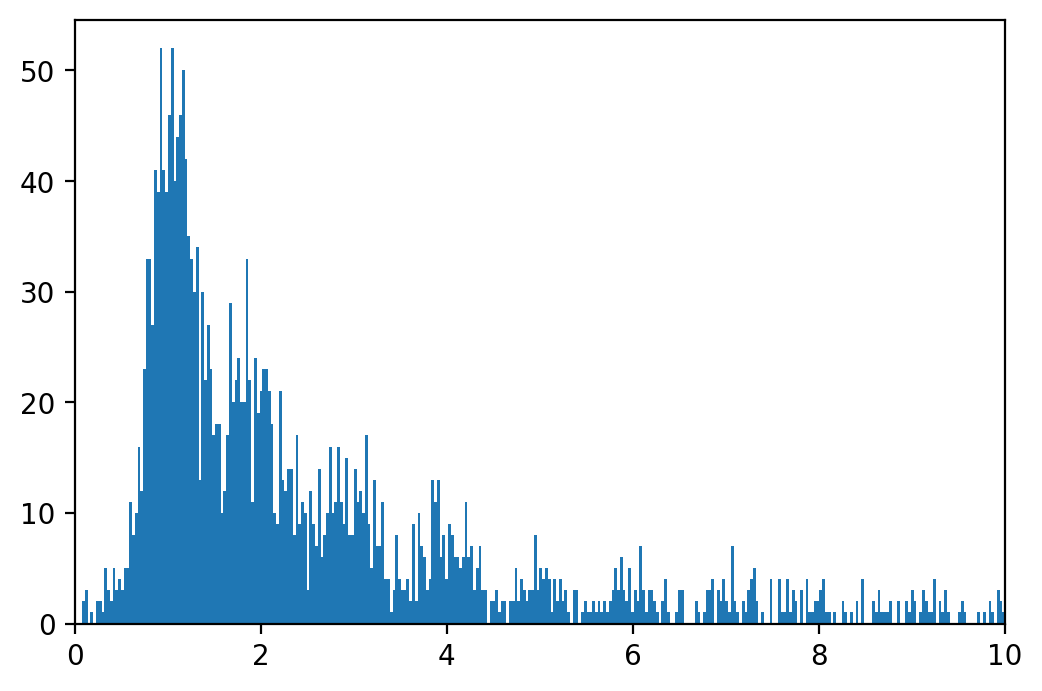

In [5]:
_=plt.hist(train.query("NAN == 1")["LOS"], bins = 1000)
plt.xlim(0,10)

In [6]:
y=train["LOS"]
train.drop("LOS", axis = 1,inplace = True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.25, random_state = 123)
X_trainf, X_testf, y_trainf, y_testf= X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [8]:
cat = ["ICD9_diagnosis", "DIAGNOSIS"]

In [10]:
X_train.shape

(10380, 53)

In [11]:
sc = Normalizer()
enc = TargetEncoder(min_samples_leaf=5)
X_train[cat] = enc.fit_transform(X_train[cat], y_train) 
test[cat] = enc.transform(test[cat])
X_test[cat] = enc.transform(X_test[cat])

X_train.drop(["Glucose_Min", "Glucose_Max", "Glucose_Mean"], axis = 1, inplace = True)
X_test.drop(["Glucose_Min", "Glucose_Max", "Glucose_Mean"], axis = 1, inplace = True)
test.drop(["Glucose_Min", "Glucose_Max", "Glucose_Mean"], axis = 1, inplace = True)

hasnan = []
for n in X_train.columns:
    if X_train[n].isnull().values.any() == True:
        hasnan.append(n)
hasnan2 = []        
for n in test.columns:
    if test[n].isnull().values.any() == True:
        hasnan2.append(n)
hasnan3 = []        
for n in X_test.columns:
    if X_test[n].isnull().values.any() == True:
        hasnan3.append(n)
        
        
X_train[hasnan] = X_train[hasnan].apply(lambda x: x.fillna(x.mean()),axis=0)
test[hasnan2] = test[hasnan2].apply(lambda x: x.fillna(x.mean()),axis=0)
X_test[hasnan3] = X_test[hasnan3].apply(lambda x: x.fillna(x.mean()),axis=0)

X_train = pd.concat([y_train, X_train],axis = 1)
X_test = pd.concat([y_test, X_test],axis = 1)


X_train = X_train.query("NAN != 1")
X_test = X_test.query("NAN != 1")

y_train = X_train["LOS"]
y_test = X_test["LOS"]
X_train.drop("LOS", axis =1, inplace = True)
X_test.drop("LOS", axis =1, inplace = True)

X_test.drop("NAN", inplace = True, axis =1)
test.drop("NAN", inplace = True, axis =1)
X_train.drop("NAN", inplace = True, axis =1)

In [12]:
X_train.shape

(8427, 49)

In [13]:
train_dum = train.iloc[:,33:]


In [14]:
dum = list(train_dum.columns)
dum.append("GENDER")
ss = list(set(X_train.columns) - set(dum))
ss

['MeanBP_Mean',
 'num_dis',
 'AGE',
 'SpO2_Mean',
 'DiasBP_Mean',
 'HeartRate_Max',
 'TempC_Mean',
 'RespRate_Min',
 'TempC_Max',
 'nthstay',
 'DIAGNOSIS',
 'MeanBP_Max',
 'DiasBP_Max',
 'HeartRate_Min',
 'TempC_Min',
 'num_stays',
 'SpO2_Max',
 'HeartRate_Mean',
 'RespRate_Mean',
 'SysBP_Min',
 'DiasBP_Min',
 'SysBP_Mean',
 'SpO2_Min',
 'RespRate_Max',
 'dis',
 'SysBP_Max',
 'ICD9_diagnosis',
 'MeanBP_Min']

In [15]:
X_train[ss].isnull().values.any()

False

In [16]:
X_train[ss] =sc.fit_transform(X_train[ss])
X_test[ss] = sc.transform(X_test[ss])
test[ss] = sc.transform(test[ss]) 


In [17]:
X_trainf.shape, X_testf.shape, y_trainf.shape, y_testf.shape

((10380, 53), (3460, 53), (10380,), (3460,))

In [18]:
X_train.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,GENDER,DIAGNOSIS,ICD9_diagnosis,num_stays,num_dis,dis,nthstay,AGE,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,FIRST_CAREUNIT_CCU,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU
6748,0.266459,0.360159,0.306207,0.213753,0.322093,0.265568,0.120053,0.207897,0.159328,0.140550,0.228393,0.183326,0.026353,0.108340,0.052831,0.104111,0.109805,0.105723,0.254746,0.292812,0.279416,0,0.009384,0.004571,0.011712,0.038066,0.025316,0.008784,0.128837,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1578,0.224315,0.327845,0.258346,0.232942,0.350851,0.291084,0.092027,0.178302,0.147793,0.132288,0.212812,0.180927,0.069020,0.126537,0.089510,0.106566,0.111039,0.108882,0.261701,0.287583,0.277158,1,0.008796,0.009842,0.002876,0.063268,0.029267,0.002876,0.241570,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
13783,0.140999,0.195580,0.168214,0.281999,0.493498,0.390275,0.111435,0.222870,0.160456,0.156919,0.300192,0.220522,0.031839,0.059129,0.046772,0.081997,0.085155,0.083116,0.206951,0.222870,0.217791,1,0.007329,0.007374,0.002274,0.022742,0.014940,0.002274,0.136451,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
12816,0.267388,0.381318,0.336280,0.262737,0.367367,0.326823,0.099980,0.174383,0.147208,0.148807,0.225536,0.191206,0.016276,0.065103,0.047536,0.086158,0.088742,0.087751,0.169733,0.225536,0.219723,0,0.005905,0.014900,0.002325,0.018601,0.020740,0.002325,0.169733,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
10560,0.166553,0.246310,0.206489,0.272114,0.459779,0.372428,0.107907,0.215815,0.174331,0.154824,0.269768,0.224025,0.021112,0.075066,0.037933,0.083407,0.087056,0.085662,0.208777,0.234581,0.225550,1,0.007175,0.006260,0.009383,0.058645,0.023316,0.004692,0.161861,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [19]:
import kerastuner as kt
from keras import layers as l
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MSE

import matplotlib.pyplot as plt

from rbflayer import RBFLayer, InitCentersRandom
from kmeans_initializer import InitCentersKMeans
from initializer import InitFromFile


In [34]:
N_INPUTS = X_test.shape[1]

class MyTuner(kt.tuners.RandomSearch): 
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size',values=[32, 64, 128, 256],default=64)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [22]:

def reg(hp):
    
    model = Sequential()


    units = hp.Int('units',min_value=32,max_value=256,default=32,step=16)
    drop = hp.Float('dropout_1',min_value=0.0,max_value=0.5,default=0.25,step=0.05)
    betas = hp.Float('betas',min_value=0.0,max_value=5,default=2,step=0.1)

    
    rbflayer = RBFLayer(units,
                        initializer=InitCentersKMeans(X_train), 
                        betas=betas,
                        input_shape=(N_INPUTS,))
    
    model.add(rbflayer)
    model.add(l.Dropout(rate = drop))
    model.add(Dense(1, use_bias=False))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4,max_value=1e-2,default=1e-3, sampling='LOG')),
                  loss=hp.Choice('loss',values=['mse', 'mae'],default='mae'),metrics=['mae'])
    return model


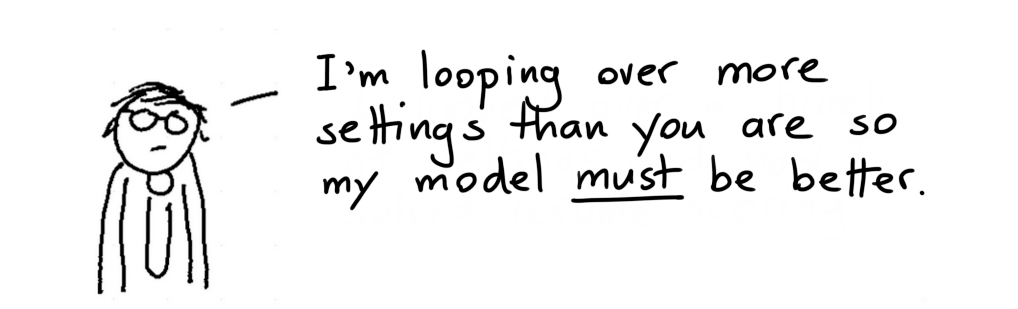
-koaning.io

In [38]:
tuner = MyTuner(reg, objective = "val_mae", max_trials = 100, project_name = 'RBF')
tuner.search(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)])

Trial 100 Complete [00h 00m 12s]
val_mae: 2.7519049644470215

Best val_mae So Far: 2.158961772918701
Total elapsed time: 00h 14m 02s
INFO:tensorflow:Oracle triggered exit


In [75]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, mae = best_model.evaluate(X_test, y_test)
best_model.summary()
tuner.results_summary()

88/88 [==============================] - 0s 2ms/step - loss: 2.2022 - mae: 2.2022
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rbf_layer (RBFLayer)         (None, 64)                3200      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 64        
Total params: 3,264
Trainable params: 3,264
Non-trainable params: 0
_________________________________________________________________
Results summary
Results in .\RBF
Showing 10 best trials
Objective(name='val_mae', direction='min')
Trial summary
Hyperparameters:
units: 64
dropout_1: 0.35000000000000003
betas: 0.2
learning_rate: 0.0010309260084789597
loss: mae
batch_size: 256
Score: 2.158961772918701
Trial summary
Hyperparameters:
u

In [76]:
pred = best_model.predict(X_train)

(0.0, 5.0)

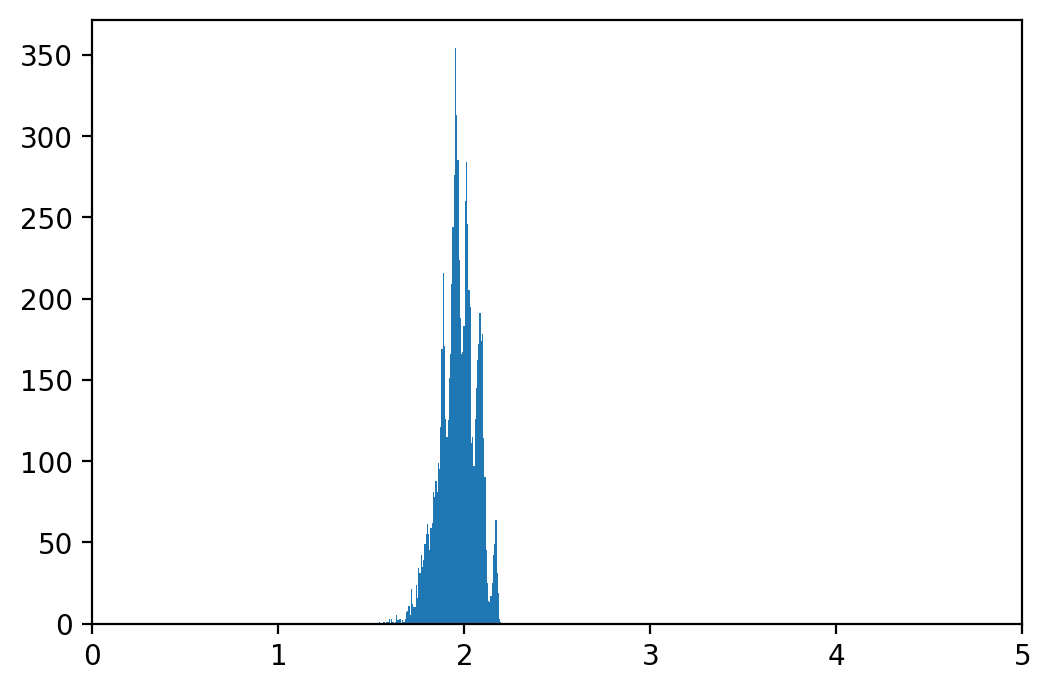

In [77]:
preD =pred

_=plt.hist(preD,bins=100)
plt.xlim(0,5)


In [ ]:
def submit(prediction, name):
    my_submission = submission_csv 
    my_submission["LOS"] =  prediction
    my_submission = my_submission
    my_submission.to_csv(name, index=False)
submit(very_nice, "dfsfg.csv")